In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.preprocessing import PowerTransformer
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [20]:
train_data = pd.read_csv('train.csv')
train_h_data = pd.read_csv('train_hourly.csv')
test_data = pd.read_csv('test.csv')
test_h_data = pd.read_csv('test_hourly.csv')

train_h_grouped_data = train_h_data.copy()

train_h_grouped_data["time"] = pd.to_datetime(train_h_grouped_data["time"]).dt.date
train_h_grouped_data["time"] = train_h_grouped_data["time"].apply(str) 

def data_preparation(df, df_h_grouped_data):
    df_h_avg_data = df_h_grouped_data.groupby(['time', 'city']).mean().reset_index().copy()
    df_h_max_data = df_h_grouped_data.groupby(['time', 'city']).max().reset_index().copy()
    df_h_min_data = df_h_grouped_data.groupby(['time', 'city']).min().reset_index().copy()
    df_h_sum_data = df_h_grouped_data.groupby(['time', 'city']).sum().reset_index().copy()

    df_h_max_data = df_h_max_data.add_prefix('max_').rename(columns={'max_city': 'city', 'max_time': 'time'})
    df_h_min_data = df_h_min_data.add_prefix('min_').rename(columns={'min_city': 'city', 'min_time': 'time'})
    df_h_avg_data = df_h_avg_data.add_prefix('avg_').rename(columns={'avg_city': 'city', 'avg_time': 'time'})
    df_h_sum_data = df_h_sum_data.add_prefix('sum_').rename(columns={'sum_city': 'city', 'sum_time': 'time'})

    cleaned_df = df.merge(df_h_max_data, on=['city', 'time'])
    cleaned_df = cleaned_df.merge(df_h_min_data, on=['city', 'time'])
    cleaned_df = cleaned_df.merge(df_h_avg_data, on=['city', 'time'])
    cleaned_df = cleaned_df.merge(df_h_sum_data, on=['city', 'time'])

    cleaned_df = cleaned_df.drop([
        'temperature_2m_max (°C)',
        'temperature_2m_min (°C)',
        'apparent_temperature_max (°C)',
        'apparent_temperature_min (°C)',
        'snowfall_sum (cm)',
        'windspeed_10m_max (km/h)',
        'windgusts_10m_max (km/h)',
        'shortwave_radiation_sum (MJ/m²)',
    ], axis = 1)

    return cleaned_df

# Preparation Data train
train_h_grouped_data = pd.read_csv('train_hourly_no_null.csv')
cleaned_train = data_preparation(train_data, train_h_grouped_data)
cleaned_train = cleaned_train.dropna(subset=['rain_sum (mm)']).drop(['time','elevation', 'sunrise (iso8601)', 'sunset (iso8601)'], axis=1)

# fillna
cleaned_train_avg_data = train_h_grouped_data.groupby(['time', 'city']).mean().reset_index().copy()
cleaned_train['winddirection_10m_dominant (°)'].fillna(cleaned_train_avg_data['winddirection_10m (°)'], inplace=True)

# Preparation Data Test
test_h_grouped_data = test_h_data.copy()
test_h_grouped_data["time"] = pd.to_datetime(test_h_grouped_data["time"]).dt.date.apply(str) 
cleaned_test = data_preparation(test_data, test_h_grouped_data)

Modelling

In [53]:
cleaned_train.loc[cleaned_train['rain_sum (mm)'] > 1, 'status'] = 1
cleaned_train.loc[cleaned_train['rain_sum (mm)'] <= 1, 'status'] = 0

Text(0.5, 1.0, 'Raining')

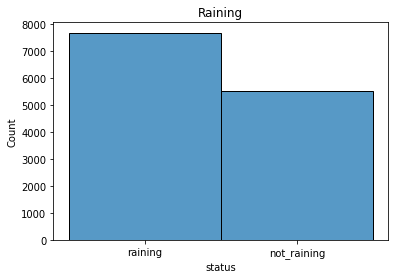

In [30]:
plt.figure()
sns.histplot(data=cleaned_train, x='status')
plt.title('Raining')

In [74]:
cleaned_train_rain = cleaned_train.loc[cleaned_train['status'] == 1] 
cleaned_train_not_rain = cleaned_train.loc[cleaned_train['status'] == 0] 

Raining

In [91]:
cleaned_train_rain_all = cleaned_train_rain.drop(['status'], axis=1)
cleaned_train_rain_all = pd.get_dummies(cleaned_train_rain_all, columns=['city'], drop_first=True)

def define_data():
    X = cleaned_train_rain_all.drop(columns=['rain_sum (mm)']).values
    y = cleaned_train_rain_all['rain_sum (mm)'].values
    return X, y

def getPermuImportance(model):
    model.fit(X_train, y_train)
    perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
    return eli5.show_weights(perm, feature_names = cleaned_train_rain_all.drop(columns=['rain_sum (mm)']).columns.tolist())

X,y = define_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)

model = XGBRegressor()
getPermuImportance(model)

Weight,Feature
0.5590 ± 0.0426,max_soil_moisture_7_to_28cm (m³/m³)
0.2164 ± 0.0188,max_soil_moisture_0_to_7cm (m³/m³)
0.2132 ± 0.0217,avg_relativehumidity_2m (%)
0.1817 ± 0.0290,min_soil_moisture_7_to_28cm (m³/m³)
0.1154 ± 0.0264,min_soil_moisture_100_to_255cm (m³/m³)
0.0574 ± 0.0098,avg_soil_moisture_28_to_100cm (m³/m³)
0.0393 ± 0.0107,sum_cloudcover (%)
0.0336 ± 0.0080,max_cloudcover_mid (%)
0.0324 ± 0.0064,max_cloudcover_low (%)
0.0314 ± 0.0043,min_soil_moisture_0_to_7cm (m³/m³)


In [93]:
data = cleaned_train_rain[['rain_sum (mm)', 'max_soil_moisture_0_to_7cm (m³/m³)', 'avg_relativehumidity_2m (%)', 'min_soil_moisture_7_to_28cm (m³/m³)', 'min_soil_moisture_100_to_255cm (m³/m³)']]

X = data.drop(columns=['rain_sum (mm)']).values
y = data['rain_sum (mm)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)

model = XGBRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_pred)
ATrS =  model.score(X_train,y_train)
ATeS = model.score(X_test,y_test)

print(MSE)

61.71166859226902


Not Raining

In [75]:
cleaned_train_not_rain_all = cleaned_train_not_rain.drop(['status'], axis=1)
cleaned_train_not_rain_all = pd.get_dummies(cleaned_train_not_rain_all, columns=['city'], drop_first=True)

def define_data():
    X = cleaned_train_rain_all.drop(columns=['rain_sum (mm)']).values
    y = cleaned_train_rain_all['rain_sum (mm)'].values
    return X, y

def getPermuImportance(model):
    model.fit(X_train, y_train)
    perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
    return eli5.show_weights(perm, feature_names = cleaned_train_not_rain_all.drop(columns=['rain_sum (mm)']).columns.tolist())

X,y = define_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)

model = CatBoostRegressor(bootstrap_type='Bayesian', depth=5, iterations=505, l2_leaf_reg=9, learning_rate=0.28379997344947866)
getPermuImportance(model)

0:	learn: 9.3932078	total: 17.7ms	remaining: 8.9s
1:	learn: 8.7584856	total: 34ms	remaining: 8.56s
2:	learn: 8.3445764	total: 52.3ms	remaining: 8.76s
3:	learn: 8.0258850	total: 68.5ms	remaining: 8.58s
4:	learn: 7.7565664	total: 86.4ms	remaining: 8.63s
5:	learn: 7.6989961	total: 104ms	remaining: 8.64s
6:	learn: 7.5634841	total: 119ms	remaining: 8.47s
7:	learn: 7.3129975	total: 135ms	remaining: 8.36s
8:	learn: 7.2685175	total: 151ms	remaining: 8.3s
9:	learn: 7.1240484	total: 178ms	remaining: 8.8s
10:	learn: 6.9909579	total: 225ms	remaining: 10.1s
11:	learn: 6.9532786	total: 247ms	remaining: 10.2s
12:	learn: 6.9400199	total: 266ms	remaining: 10.1s
13:	learn: 6.9182746	total: 296ms	remaining: 10.4s
14:	learn: 6.8760700	total: 323ms	remaining: 10.6s
15:	learn: 6.8515327	total: 344ms	remaining: 10.5s
16:	learn: 6.7423420	total: 377ms	remaining: 10.8s
17:	learn: 6.6747765	total: 404ms	remaining: 10.9s
18:	learn: 6.6051044	total: 430ms	remaining: 11s
19:	learn: 6.5795931	total: 468ms	remaining

Weight,Feature
1.0244 ± 0.0234,max_soil_moisture_7_to_28cm (m³/m³)
0.5085 ± 0.0377,min_soil_moisture_7_to_28cm (m³/m³)
0.3264 ± 0.0154,max_soil_moisture_0_to_7cm (m³/m³)
0.1025 ± 0.0094,min_soil_moisture_0_to_7cm (m³/m³)
0.0744 ± 0.0119,avg_relativehumidity_2m (%)
0.0446 ± 0.0102,min_soil_moisture_28_to_100cm (m³/m³)
0.0428 ± 0.0090,min_soil_moisture_100_to_255cm (m³/m³)
0.0315 ± 0.0042,max_cloudcover_mid (%)
0.0271 ± 0.0117,max_cloudcover_low (%)
0.0252 ± 0.0072,sum_shortwave_radiation (W/m²)


In [76]:
data = cleaned_not_rain[['rain_sum (mm)','max_soil_moisture_0_to_7cm (m³/m³)', 'max_soil_moisture_7_to_28cm (m³/m³)', 'min_soil_moisture_0_to_7cm (m³/m³)', 'min_soil_moisture_7_to_28cm (m³/m³)', 'avg_relativehumidity_2m (%)']]

X = data.drop(columns=['rain_sum (mm)']).values
y = data['rain_sum (mm)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)

model = CatBoostRegressor(bootstrap_type='Bayesian', depth=5, iterations=505, l2_leaf_reg=9, learning_rate=0.28379997344947866)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_pred)
ATrS =  model.score(X_train,y_train)
ATeS = model.score(X_test,y_test)

print(MSE)

0:	learn: 0.2665248	total: 2.09ms	remaining: 1.05s
1:	learn: 0.2597893	total: 7.48ms	remaining: 1.88s
2:	learn: 0.2551321	total: 9.21ms	remaining: 1.54s
3:	learn: 0.2525992	total: 12.2ms	remaining: 1.53s
4:	learn: 0.2502078	total: 14.6ms	remaining: 1.46s
5:	learn: 0.2490759	total: 19.1ms	remaining: 1.59s
6:	learn: 0.2482969	total: 20.7ms	remaining: 1.47s
7:	learn: 0.2477938	total: 22.3ms	remaining: 1.39s
8:	learn: 0.2465657	total: 25.3ms	remaining: 1.4s
9:	learn: 0.2455468	total: 28.7ms	remaining: 1.42s
10:	learn: 0.2448021	total: 30.8ms	remaining: 1.38s
11:	learn: 0.2441972	total: 32.7ms	remaining: 1.34s
12:	learn: 0.2436624	total: 34.1ms	remaining: 1.29s
13:	learn: 0.2431922	total: 35.5ms	remaining: 1.24s
14:	learn: 0.2430009	total: 36.8ms	remaining: 1.2s
15:	learn: 0.2427298	total: 38.1ms	remaining: 1.16s
16:	learn: 0.2423700	total: 43.2ms	remaining: 1.24s
17:	learn: 0.2420250	total: 44.8ms	remaining: 1.21s
18:	learn: 0.2414835	total: 46.4ms	remaining: 1.19s
19:	learn: 0.2412116	tot

In [79]:
len(cleaned_train_rain)

7669

In [80]:
len(cleaned_train_not_rain)

5529

In [84]:
(7669 * 41.67652679987434 + 5529 * 0.06133359049559267) / (7669 + 5529)

24.242794169577696